In [1]:
import numpy as np
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout, Flatten, BatchNormalization
# sequence data packages
from keras.preprocessing import sequence
import itertools
import random
import dataUtils as du
import model_utils as mutls
from sklearn import metrics

C:\Users\Yang\.conda\envs\test_speedcom\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
df=du.DataUtils.readData('cleaned_data_emission.tsv')


   #      Name  Epsilon      Solvent  Quantum Yield    Solvent.1  \
0  1   Benzene      210  cyclohexane          0.053       hexane   
1  2   Toluene     2860  cyclohexane          0.170  cyclohexane   
2  3  o-Xylene      254  cyclohexane          0.170       hexane   
3  4  m-Xylene      284  cyclohexane          0.130       hexane   
4  5  p-Xylene      770  cyclohexane          0.220       hexane   

                            File                         File.1  Absorption  \
0    A01_71-43-2_Benzene.abs.txt    A01_71-43-2_Benzene.ems.txt      254.75   
1   A02_108-88-3_Toluene.abs.txt   A02_108-88-3_Toluene.ems.txt      261.75   
2   A03_95-47-6_o-Xylene.abs.txt   A03_95-47-6_o-Xylene.ems.txt      263.00   
3  A04_108-38-3_m-Xylene.abs.txt  A04_108-38-3_m-Xylene.ems.txt      265.00   
4  A05_106-42-3_p-Xylene.abs.txt  A05_106-42-3_p-Xylene.ems.txt      275.00   

            SMILES  Emission  
0      C1=CC=CC=C1     287.0  
1     CC1=CC=CC=C1     289.5  
2    CC1=CC=CC=C1C     

In [3]:
x_str, y_wl=du.DataUtils.get_xy(df,x_col_index=9,y_col_index=8)
maxlen = du.DataUtils.get_max_len(x_str)


In [4]:
wordmap=du.DataUtils.get_wordmap(x_str)

In [5]:
len(wordmap)

42

In [6]:
x_encode=du.DataUtils.numeric_encoding(x_str,uniform_length=maxlen+5,word_map=wordmap)

In [7]:
maxlen

274

In [8]:
X_train, X_test, y_train, y_test=du.DataUtils.splitData(x_encode, y_wl, ratio=0.2)

In [9]:
X_train

array([[ 8,  0,  0, ..., 16, 16, 16],
       [ 8,  0, 12, ..., 16, 16, 16],
       [ 8,  0,  0, ..., 16, 16, 16],
       ...,
       [ 8,  0, 40, ..., 16, 16, 16],
       [ 8,  0,  0, ..., 16, 16, 16],
       [ 8,  0,  0, ..., 16, 16, 16]], dtype=int8)

(array([93., 58., 20., 36., 24., 24., 22.,  7.,  3.,  4.]),
 array([203. , 264.5, 326. , 387.5, 449. , 510.5, 572. , 633.5, 695. ,
        756.5, 818. ]),
 <a list of 10 Patch objects>)

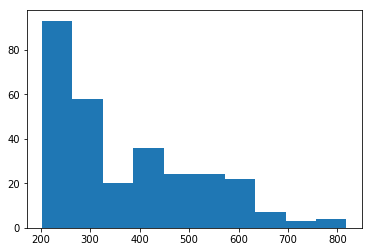

In [107]:
plt.hist(y_wl.tolist())

#### 1st model, use all data and numeric encoding of smiles, added embedding layer

In [108]:
hidden_size = 50
model = Sequential()
model.add(Embedding(len(wordmap), hidden_size, input_length=maxlen+5))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(Dense(hidden_size, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

In [45]:
model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mean_absolute_error'])
model.summary() ##use mean_squared_error loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 279, 50)           2100      
_________________________________________________________________
lstm_5 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
batch_normalization_2 (Batch (None, 279, 50)           200       
_________________________________________________________________
lstm_6 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 279, 50)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 279, 50)           0         
__________

In [46]:
model.fit(X_train, y_train.reshape(-1,1), batch_size=32, validation_data=(X_test, y_test.reshape(-1,1)), epochs=100)

Train on 232 samples, validate on 59 samples
Epoch 1/100
232/232 [==============================] - 6s 25ms/step - loss: 154269.0291 - mean_absolute_error: 365.8581 - val_loss: 146193.4251 - val_mean_absolute_error: 352.9004
Epoch 2/100
232/232 [==============================] - 3s 13ms/step - loss: 121947.0067 - mean_absolute_error: 317.8559 - val_loss: 91614.8841 - val_mean_absolute_error: 262.2590
Epoch 3/100
232/232 [==============================] - 3s 13ms/step - loss: 63936.4386 - mean_absolute_error: 200.9835 - val_loss: 34240.5936 - val_mean_absolute_error: 139.3730
Epoch 4/100
232/232 [==============================] - 3s 13ms/step - loss: 26975.2142 - mean_absolute_error: 139.6733 - val_loss: 30032.4069 - val_mean_absolute_error: 148.4147
Epoch 5/100
232/232 [==============================] - 3s 13ms/step - loss: 27271.5331 - mean_absolute_error: 146.6160 - val_loss: 28314.3249 - val_mean_absolute_error: 118.2080
Epoch 6/100
232/232 [==============================] - 3s 13ms

Epoch 94/100
232/232 [==============================] - 4s 18ms/step - loss: 2707.2912 - mean_absolute_error: 40.2975 - val_loss: 11710.2650 - val_mean_absolute_error: 69.2264
Epoch 95/100
232/232 [==============================] - 4s 17ms/step - loss: 2499.6236 - mean_absolute_error: 37.2099 - val_loss: 9906.7375 - val_mean_absolute_error: 63.6058
Epoch 96/100
232/232 [==============================] - 3s 15ms/step - loss: 2414.1696 - mean_absolute_error: 37.2467 - val_loss: 10987.3721 - val_mean_absolute_error: 67.3879
Epoch 97/100
232/232 [==============================] - 3s 14ms/step - loss: 2211.2527 - mean_absolute_error: 35.5759 - val_loss: 10126.3528 - val_mean_absolute_error: 66.4209
Epoch 98/100
232/232 [==============================] - 3s 14ms/step - loss: 2188.4062 - mean_absolute_error: 35.1079 - val_loss: 10024.4159 - val_mean_absolute_error: 65.1970
Epoch 99/100
232/232 [==============================] - 3s 15ms/step - loss: 2092.7358 - mean_absolute_error: 33.8415 - v

### plot error after 100 epochs

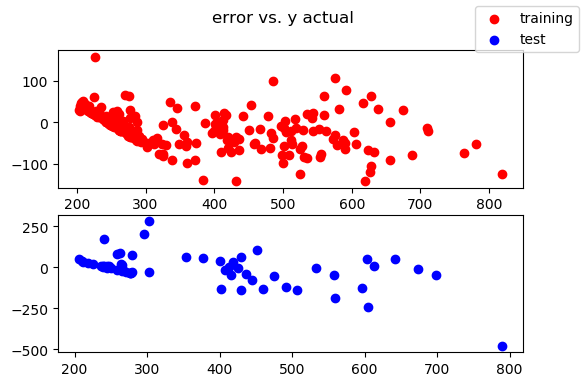

In [47]:
mutls.ModelUtils.plot_model_error(X_train, X_test, y_train, y_test, model)

#### Calculate metrics after 100 epochs

In [48]:
metrics.r2_score(y_train.reshape(-1,1),model.predict(X_train))

0.8945033837637489

In [49]:
metrics.r2_score(y_test.reshape(-1,1),model.predict(X_test))

0.4804887724012624

In [50]:
metrics.mean_absolute_error(y_train.reshape(-1,1),model.predict(X_train))

35.05310918084506

In [51]:
metrics.mean_absolute_error(y_test.reshape(-1,1),model.predict(X_test))

66.29686413781117

#### another 50 epochs 

In [52]:
model.fit(X_train, y_train.reshape(-1,1), batch_size=32, validation_data=(X_test, y_test.reshape(-1,1)), epochs=50)

Train on 232 samples, validate on 59 samples
Epoch 1/50
232/232 [==============================] - 3s 13ms/step - loss: 3455.1483 - mean_absolute_error: 42.6024 - val_loss: 10947.4573 - val_mean_absolute_error: 68.9825
Epoch 2/50
232/232 [==============================] - 3s 14ms/step - loss: 3355.9276 - mean_absolute_error: 41.8084 - val_loss: 8461.3985 - val_mean_absolute_error: 62.6919
Epoch 3/50
232/232 [==============================] - 3s 14ms/step - loss: 2623.5653 - mean_absolute_error: 38.6117 - val_loss: 9504.9016 - val_mean_absolute_error: 63.4574
Epoch 4/50
232/232 [==============================] - 4s 15ms/step - loss: 2587.0354 - mean_absolute_error: 37.8825 - val_loss: 8388.7515 - val_mean_absolute_error: 61.2534
Epoch 5/50
232/232 [==============================] - 3s 14ms/step - loss: 2344.6666 - mean_absolute_error: 37.0549 - val_loss: 9852.4581 - val_mean_absolute_error: 67.8470
Epoch 6/50
232/232 [==============================] - 3s 13ms/step - loss: 2207.2850 - me

Epoch 48/50
232/232 [==============================] - 3s 14ms/step - loss: 1535.9048 - mean_absolute_error: 28.1544 - val_loss: 10680.8898 - val_mean_absolute_error: 68.7111
Epoch 49/50
232/232 [==============================] - 3s 14ms/step - loss: 1360.7975 - mean_absolute_error: 27.6975 - val_loss: 9343.6686 - val_mean_absolute_error: 63.2979
Epoch 50/50
232/232 [==============================] - 3s 13ms/step - loss: 1333.0976 - mean_absolute_error: 26.9428 - val_loss: 8200.8606 - val_mean_absolute_error: 60.1830


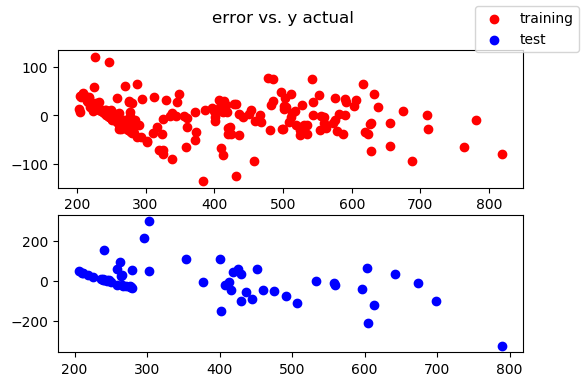

In [53]:
mutls.ModelUtils.plot_model_error(X_train, X_test, y_train, y_test, model)

In [54]:
metrics.r2_score(y_train.reshape(-1,1),model.predict(X_train))

0.9390436975774493

In [55]:
metrics.r2_score(y_test.reshape(-1,1),model.predict(X_test))

0.6184142676059865

In [56]:
metrics.mean_absolute_error(y_train.reshape(-1,1),model.predict(X_train))

25.93636150228566

In [57]:
metrics.mean_absolute_error(y_test.reshape(-1,1),model.predict(X_test))

60.18302814031051

#### another 25 epochs 

In [59]:
model.fit(X_train, y_train.reshape(-1,1), batch_size=32, validation_data=(X_test, y_test.reshape(-1,1)), epochs=25)

Train on 232 samples, validate on 59 samples
Epoch 1/25
232/232 [==============================] - 3s 13ms/step - loss: 1107.1168 - mean_absolute_error: 24.2664 - val_loss: 9444.8452 - val_mean_absolute_error: 63.2462
Epoch 2/25
232/232 [==============================] - 3s 13ms/step - loss: 1074.5614 - mean_absolute_error: 23.9291 - val_loss: 9548.1624 - val_mean_absolute_error: 62.6037
Epoch 3/25
232/232 [==============================] - 3s 13ms/step - loss: 1033.6848 - mean_absolute_error: 23.4231 - val_loss: 9296.1054 - val_mean_absolute_error: 62.4990
Epoch 4/25
232/232 [==============================] - 3s 13ms/step - loss: 1002.1034 - mean_absolute_error: 23.7485 - val_loss: 8938.2814 - val_mean_absolute_error: 60.0269
Epoch 5/25
232/232 [==============================] - 3s 13ms/step - loss: 1111.6081 - mean_absolute_error: 23.8538 - val_loss: 9492.7164 - val_mean_absolute_error: 64.5240
Epoch 6/25
232/232 [==============================] - 3s 13ms/step - loss: 1052.8282 - mea

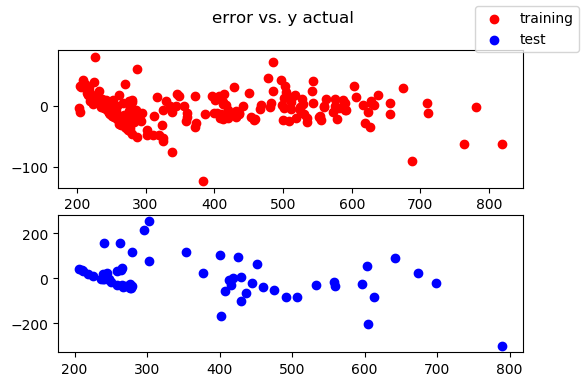

In [60]:
mutls.ModelUtils.plot_model_error(X_train, X_test, y_train, y_test, model)

In [62]:
print("train R2 is %s" % metrics.r2_score(y_train.reshape(-1,1),model.predict(X_train)))
print("test R2 is %s" % metrics.r2_score(y_test.reshape(-1,1),model.predict(X_test)))

train R2 is 0.9681928487601932
test R2 is 0.6416524410660247


In [63]:
print("train mean abs err is %s" % metrics.mean_absolute_error(y_train.reshape(-1,1),model.predict(X_train)))
print("test mean abs err is %s" % metrics.mean_absolute_error(y_test.reshape(-1,1),model.predict(X_test)))

train mean abs err is 18.85860572551859
test mean abs err is 60.34719202073954


After 175 epochs total, train absolute error ~18nm, val absolute error ~60

#### Model 1.2 change batchnormalization order

In [102]:
x_str, y_wl=du.DataUtils.get_xy(df,x_col_index=9,y_col_index=8)
maxlen = du.DataUtils.get_max_len(x_str)
wordmap=du.DataUtils.get_wordmap(x_str)
x_encode=du.DataUtils.numeric_encoding(x_str,uniform_length=maxlen+5,word_map=wordmap)
X_train, X_test, y_train, y_test=du.DataUtils.splitData(x_encode, y_wl, ratio=0.2)

In [103]:
hidden_size = 50
model = Sequential()
model.add(Embedding(len(wordmap), hidden_size, input_length=maxlen+5))
model.add(BatchNormalization())
model.add(LSTM(hidden_size, return_sequences=True))

model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(Dense(hidden_size, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

In [104]:
model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mean_absolute_error'])
model.summary() ##use mean_squared_error loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 279, 50)           2100      
_________________________________________________________________
batch_normalization_11 (Batc (None, 279, 50)           200       
_________________________________________________________________
lstm_31 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
lstm_32 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
dropout_19 (Dropout)         (None, 279, 50)           0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
dropout_20 (Dropout)         (None, 279, 50)           0         
__________

In [105]:
history=model.fit(X_train, y_train.reshape(-1,1), batch_size=32, validation_data=(X_test, y_test.reshape(-1,1)), epochs=100)

Train on 232 samples, validate on 59 samples
Epoch 1/100
232/232 [==============================] - 12s 50ms/step - loss: 154732.8696 - mean_absolute_error: 366.3749 - val_loss: 145591.3591 - val_mean_absolute_error: 351.6571
Epoch 2/100
232/232 [==============================] - 4s 15ms/step - loss: 119519.1676 - mean_absolute_error: 311.3782 - val_loss: 88107.2129 - val_mean_absolute_error: 253.0229
Epoch 3/100
232/232 [==============================] - 4s 17ms/step - loss: 60104.3761 - mean_absolute_error: 184.9331 - val_loss: 32868.7005 - val_mean_absolute_error: 147.9039
Epoch 4/100
232/232 [==============================] - 4s 16ms/step - loss: 31044.5384 - mean_absolute_error: 154.6985 - val_loss: 33547.1306 - val_mean_absolute_error: 157.6952
Epoch 5/100
232/232 [==============================] - 4s 16ms/step - loss: 29126.6390 - mean_absolute_error: 152.7861 - val_loss: 25592.8634 - val_mean_absolute_error: 135.5582
Epoch 6/100
232/232 [==============================] - 4s 16m

232/232 [==============================] - 3s 14ms/step - loss: 5723.6193 - mean_absolute_error: 53.7901 - val_loss: 8734.1547 - val_mean_absolute_error: 68.1561
Epoch 48/100
232/232 [==============================] - 3s 14ms/step - loss: 5304.5862 - mean_absolute_error: 52.3854 - val_loss: 8147.3773 - val_mean_absolute_error: 66.2781
Epoch 49/100
232/232 [==============================] - 3s 14ms/step - loss: 5212.3856 - mean_absolute_error: 52.6375 - val_loss: 7804.5401 - val_mean_absolute_error: 65.2296
Epoch 50/100
232/232 [==============================] - 3s 14ms/step - loss: 4560.2322 - mean_absolute_error: 49.3452 - val_loss: 7095.9014 - val_mean_absolute_error: 62.0789
Epoch 51/100
232/232 [==============================] - 3s 14ms/step - loss: 4386.1501 - mean_absolute_error: 47.9710 - val_loss: 7121.3944 - val_mean_absolute_error: 61.8448
Epoch 52/100
232/232 [==============================] - 3s 14ms/step - loss: 4302.0929 - mean_absolute_error: 47.2138 - val_loss: 7017.358

Epoch 94/100
232/232 [==============================] - 3s 14ms/step - loss: 1730.2625 - mean_absolute_error: 31.5270 - val_loss: 8287.7038 - val_mean_absolute_error: 66.9438
Epoch 95/100
232/232 [==============================] - 3s 14ms/step - loss: 1635.2597 - mean_absolute_error: 30.2122 - val_loss: 7870.4278 - val_mean_absolute_error: 64.6444
Epoch 96/100
232/232 [==============================] - 3s 15ms/step - loss: 1636.8112 - mean_absolute_error: 30.4514 - val_loss: 8514.3589 - val_mean_absolute_error: 67.4649
Epoch 97/100
232/232 [==============================] - 3s 14ms/step - loss: 1635.8710 - mean_absolute_error: 30.2436 - val_loss: 8168.4712 - val_mean_absolute_error: 64.9704
Epoch 98/100
232/232 [==============================] - 3s 14ms/step - loss: 1516.0877 - mean_absolute_error: 29.6604 - val_loss: 7714.0748 - val_mean_absolute_error: 62.6022
Epoch 99/100
232/232 [==============================] - 3s 14ms/step - loss: 1468.0567 - mean_absolute_error: 29.6240 - val_l

train R2 is 0.9260988504998706
test R2 is 0.6341465258163198
train mean abs err is 29.708205642700197
test mean abs err is 64.57528660661083


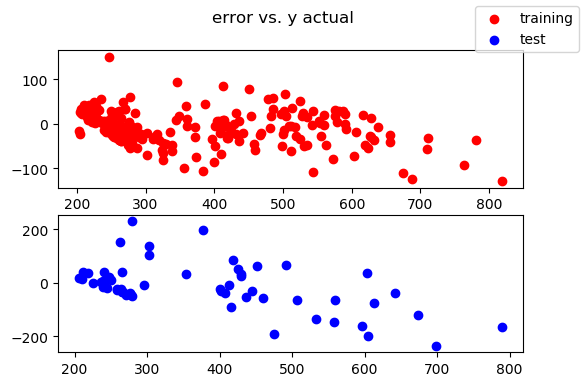

In [112]:
mutls.ModelUtils.plot_model_error(X_train, X_test, y_train, y_test, model)
print("train R2 is %s" % metrics.r2_score(y_train.reshape(-1,1),model.predict(X_train)))
print("test R2 is %s" % metrics.r2_score(y_test.reshape(-1,1),model.predict(X_test)))
print("train mean abs err is %s" % metrics.mean_absolute_error(y_train.reshape(-1,1),model.predict(X_train)))
print("test mean abs err is %s" % metrics.mean_absolute_error(y_test.reshape(-1,1),model.predict(X_test)))

(15, 80)

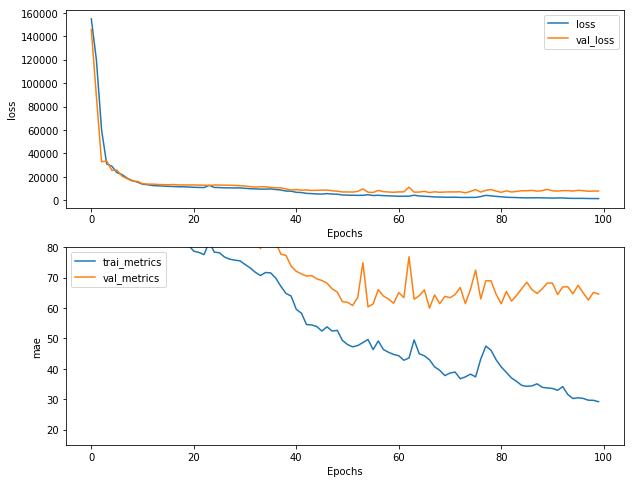

In [111]:
hist = history.history

plt.figure(figsize=(10, 8))


plt.subplot(211)
plt.plot(hist['loss'], label = 'loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
    
plt.subplot(212)
plt.plot(hist['mean_absolute_error'], label = 'trai_metrics')
plt.plot(hist['val_mean_absolute_error'], label='val_metrics')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("mae")
plt.ylim(15,80)
    

In [113]:
history1=model.fit(X_train, y_train.reshape(-1,1), batch_size=32, validation_data=(X_test, y_test.reshape(-1,1)), epochs=25)

Train on 232 samples, validate on 59 samples
Epoch 1/25
232/232 [==============================] - 3s 14ms/step - loss: 1574.3884 - mean_absolute_error: 30.0885 - val_loss: 7741.5948 - val_mean_absolute_error: 63.3389
Epoch 2/25
232/232 [==============================] - 3s 15ms/step - loss: 1461.2102 - mean_absolute_error: 29.9581 - val_loss: 7796.5970 - val_mean_absolute_error: 63.7470
Epoch 3/25
232/232 [==============================] - 3s 14ms/step - loss: 1455.4174 - mean_absolute_error: 29.6010 - val_loss: 8020.6067 - val_mean_absolute_error: 63.7119
Epoch 4/25
232/232 [==============================] - 3s 14ms/step - loss: 1323.7047 - mean_absolute_error: 28.5381 - val_loss: 8243.9472 - val_mean_absolute_error: 65.1374
Epoch 5/25
232/232 [==============================] - 3s 14ms/step - loss: 1339.6221 - mean_absolute_error: 28.3046 - val_loss: 8535.6266 - val_mean_absolute_error: 65.6746
Epoch 6/25
232/232 [==============================] - 3s 14ms/step - loss: 1208.9058 - mea

(15, 80)

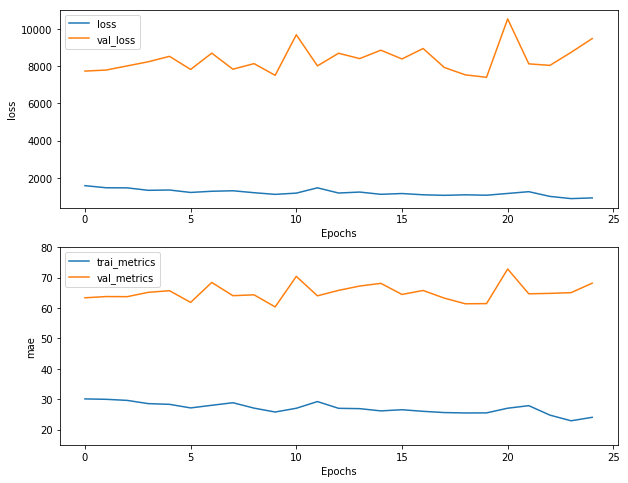

In [114]:
hist = history1.history

plt.figure(figsize=(10, 8))


plt.subplot(211)
plt.plot(hist['loss'], label = 'loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
    
plt.subplot(212)
plt.plot(hist['mean_absolute_error'], label = 'trai_metrics')
plt.plot(hist['val_mean_absolute_error'], label='val_metrics')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("mae")
plt.ylim(15,80)
    

train R2 is 0.962991478613836
test R2 is 0.5583441103334954
train mean abs err is 21.488774785008925
test mean abs err is 68.1455947100106


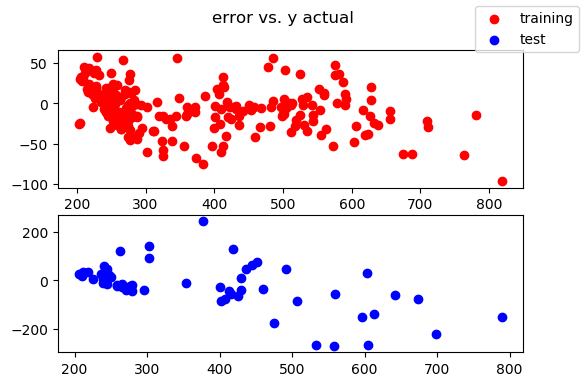

In [115]:
mutls.ModelUtils.plot_model_error(X_train, X_test, y_train, y_test, model)
print("train R2 is %s" % metrics.r2_score(y_train.reshape(-1,1),model.predict(X_train)))
print("test R2 is %s" % metrics.r2_score(y_test.reshape(-1,1),model.predict(X_test)))
print("train mean abs err is %s" % metrics.mean_absolute_error(y_train.reshape(-1,1),model.predict(X_train)))
print("test mean abs err is %s" % metrics.mean_absolute_error(y_test.reshape(-1,1),model.predict(X_test)))

### Model 2 consider transform y to make y more normal distributed, resulted in more error

In [8]:
def tranform_log(x_list, b): #log(x-b)
    return np.log(list(x_list-b))

In [9]:
y_log = tranform_log(y_wl,y_wl.min()-10)

In [10]:
def inverse_log(transformed_x,b):
    return np.exp(transformed_x)+b

(array([ 7.,  6., 15., 23., 57., 39., 21., 46., 55., 22.]),
 array([2.30258509, 2.71610175, 3.1296184 , 3.54313506, 3.95665172,
        4.37016837, 4.78368503, 5.19720168, 5.61071834, 6.02423499,
        6.43775165]),
 <a list of 10 Patch objects>)

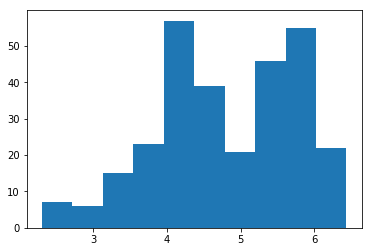

In [11]:
X_train, X_test, y_train, y_test=du.DataUtils.splitData(x_encode, y_log, ratio=0.2)
plt.hist(y_log.tolist())

In [12]:
from keras import backend as K

In [40]:
a=np.array([[1.0],[2.0]])

In [58]:
b=np.array([[3.0],[2.0]])

In [65]:
K.eval(K.mean(K.abs(K.exp(a)-K.exp(b))))

8.683627547364312

In [13]:
def mean_square_exp_error(y_true, y_pred):    
    from keras import backend as K
    first_exp = K.exp(y_pred)
    second_exp = K.exp(y_true)
    return K.mean(K.square(first_exp - second_exp))

In [15]:
hidden_size = 50
model = Sequential()
model.add(Embedding(len(wordmap), hidden_size, input_length=maxlen+5))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(Dense(hidden_size, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
model.compile(loss=mean_square_exp_error, optimizer='Adam', metrics=['mean_absolute_error'])
model.summary() ##use mean_squared_error loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 279, 50)           2100      
_________________________________________________________________
lstm_1 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 279, 50)           200       
_________________________________________________________________
lstm_2 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 279, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 279, 50)           0         
__________

In [17]:
model.fit(X_train, y_train.reshape(-1,1), batch_size=32, validation_data=(X_test, y_test.reshape(-1,1)), epochs=50)

Instructions for updating:
Use tf.cast instead.
Train on 232 samples, validate on 59 samples
Epoch 1/50
232/232 [==============================] - 6s 24ms/step - loss: 60486.9723 - mean_absolute_error: 2.4426 - val_loss: 48027.2208 - val_mean_absolute_error: 1.9256
Epoch 2/50
232/232 [==============================] - 3s 13ms/step - loss: 48812.5923 - mean_absolute_error: 2.9044 - val_loss: 54702.2860 - val_mean_absolute_error: 4.0817
Epoch 3/50
232/232 [==============================] - 3s 13ms/step - loss: 51323.1938 - mean_absolute_error: 4.0716 - val_loss: 54930.8221 - val_mean_absolute_error: 4.3720
Epoch 4/50
232/232 [==============================] - 3s 13ms/step - loss: 51530.3039 - mean_absolute_error: 4.3574 - val_loss: 55014.5936 - val_mean_absolute_error: 4.5140
Epoch 5/50
232/232 [==============================] - 3s 13ms/step - loss: 51587.7429 - mean_absolute_error: 4.4515 - val_loss: 55047.1118 - val_mean_absolute_error: 4.5765
Epoch 6/50
232/232 [======================

232/232 [==============================] - 4s 15ms/step - loss: 14545.4539 - mean_absolute_error: 0.6137 - val_loss: 19936.6175 - val_mean_absolute_error: 0.6950
Epoch 47/50
232/232 [==============================] - 3s 15ms/step - loss: 8757.6738 - mean_absolute_error: 0.5194 - val_loss: 21321.7329 - val_mean_absolute_error: 0.7381
Epoch 48/50
232/232 [==============================] - 3s 13ms/step - loss: 8044.6589 - mean_absolute_error: 0.4905 - val_loss: 13924.4006 - val_mean_absolute_error: 0.5914
Epoch 49/50
232/232 [==============================] - 3s 13ms/step - loss: 9337.7388 - mean_absolute_error: 0.5265 - val_loss: 20351.9545 - val_mean_absolute_error: 0.6967
Epoch 50/50
232/232 [==============================] - 3s 13ms/step - loss: 8680.0272 - mean_absolute_error: 0.5180 - val_loss: 12555.6790 - val_mean_absolute_error: 0.5682


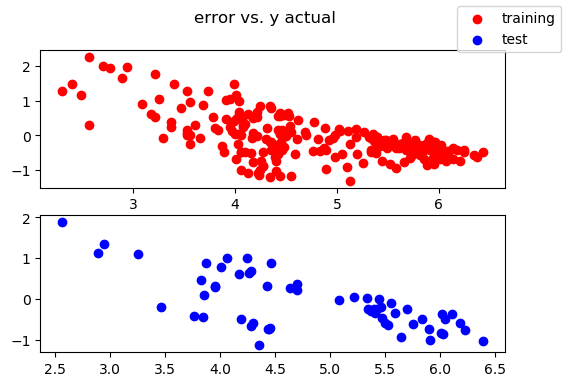

In [18]:
mutls.ModelUtils.plot_model_error(X_train, X_test, y_train, y_test, model)


In [19]:
y_train_pred_wl = inverse_log(model.predict(X_train), y_wl.min()-10)

In [20]:
y_train_acutal_wl = inverse_log(y_train, y_wl.min()-10).reshape(-1,1)

In [21]:
y_train_pred_wl-y_train_acutal_wl

array([[ -86.28240967],
       [ -50.50634766],
       [-111.78884888],
       [ -45.1633606 ],
       [   0.75140381],
       [  29.15917969],
       [ -32.59155273],
       [ -10.72637939],
       [  -8.0852356 ],
       [ -37.31462097],
       [ -23.13668823],
       [ -65.42485046],
       [  -1.92903137],
       [   5.26199341],
       [  87.29434204],
       [-261.91485596],
       [  38.9395752 ],
       [ -21.90975952],
       [ -71.52005005],
       [   2.64730835],
       [  10.6697998 ],
       [ 121.14074707],
       [ -37.75445557],
       [   9.52896118],
       [  15.15362549],
       [  -2.04443359],
       [ -69.13287354],
       [ -40.29135132],
       [ -42.33110046],
       [  -8.04071045],
       [  32.9541626 ],
       [ -73.27487183],
       [  20.0687561 ],
       [-124.92593384],
       [ -20.2726593 ],
       [-184.2532959 ],
       [ -98.02813721],
       [ -56.41390991],
       [-117.35778809],
       [ -13.86679077],
       [-128.10623779],
       [-146.135

In [22]:
y_test_pred_wl = inverse_log(model.predict(X_test), y_wl.min()-10)

In [23]:
y_test_acutal_wl = inverse_log(y_test, y_wl.min()-10).reshape(-1,1)

Text(0.5, 0.98, 'error vs. y actual')

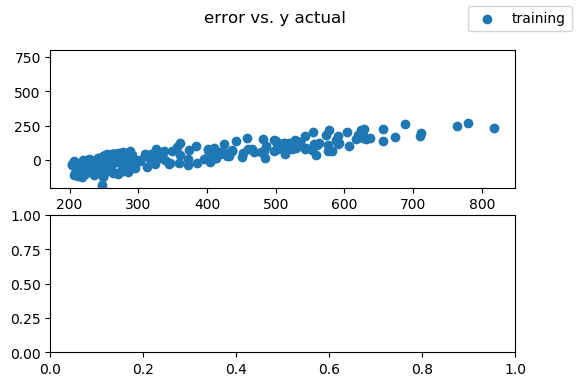

In [24]:
fig, axes = plt.subplots(2)
fig.dpi=100
axes[0].scatter(y_train_acutal_wl, y_train_acutal_wl-y_train_pred_wl,label='training')
axes[0].set_ylim(-200,800)

fig.legend()
plt.suptitle("error vs. y actual" )

The model does not work very well

### Try under sample the 200-400nm region to make the y more uniform

In [41]:
Y_category = (y_wl - 200) // 20

In [42]:
cls, counts = np.unique(Y_category, return_counts=True)
cls_counts = dict(zip(cls, counts))
print(cls_counts)

{0.0: 18, 1.0: 23, 2.0: 42, 3.0: 44, 4.0: 14, 5.0: 8, 6.0: 8, 7.0: 6, 8.0: 6, 9.0: 3, 10.0: 21, 11.0: 12, 12.0: 7, 13.0: 5, 14.0: 7, 15.0: 12, 16.0: 8, 17.0: 10, 18.0: 5, 19.0: 6, 20.0: 7, 21.0: 6, 22.0: 3, 23.0: 2, 24.0: 2, 25.0: 2, 28.0: 1, 29.0: 2, 30.0: 1}


#### To each category, keep less than 20 counts per category

In [43]:
data_cat=np.column_stack((x_str,y_wl,Y_category))

In [44]:
def subsampling(dataset, cls_max, cls_dict):
    out = []
    for row in dataset:
        cls = row[2]
        rInt = np.random.randint(0, cls_dict[cls])
        if rInt <= cls_max:
            out.append(row)
    return np.array(out)

subsampled = subsampling(data_cat, 20, cls_counts)

In [45]:
subsampled[:,1].shape

(239,)

In [46]:
x_encode=du.DataUtils.numeric_encoding(subsampled[:,0],uniform_length=maxlen+5,word_map=wordmap)

In [47]:
y_sub = subsampled[:,1]

(array([62., 37., 20., 36., 24., 24., 22.,  7.,  3.,  4.]),
 array([203. , 264.5, 326. , 387.5, 449. , 510.5, 572. , 633.5, 695. ,
        756.5, 818. ]),
 <a list of 10 Patch objects>)

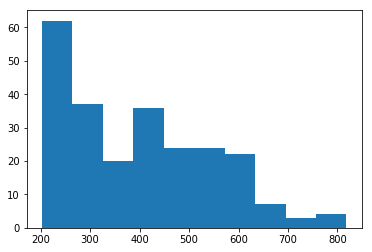

In [50]:
X_train, X_test, y_train, y_test=du.DataUtils.splitData(x_encode, y_sub, ratio=0.2)
plt.hist(y_sub.tolist())

In [66]:
hidden_size = 50
model = Sequential()
model.add(Embedding(len(wordmap), hidden_size, input_length=maxlen+5))
model.add(BatchNormalization())
model.add(LSTM(hidden_size, return_sequences=True))

model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(Dense(hidden_size, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mean_absolute_error'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 279, 50)           2100      
_________________________________________________________________
batch_normalization_6 (Batch (None, 279, 50)           200       
_________________________________________________________________
lstm_16 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
lstm_17 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 279, 50)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 279, 50)           0         
__________

In [67]:
history = model.fit(X_train, y_train.reshape(-1,1), batch_size=32, validation_data=(X_test, y_test.reshape(-1,1)), epochs=100)

Train on 191 samples, validate on 48 samples
Epoch 1/100
191/191 [==============================] - 7s 34ms/step - loss: 177906.1853 - mean_absolute_error: 394.6699 - val_loss: 165540.9531 - val_mean_absolute_error: 381.3314
Epoch 2/100
191/191 [==============================] - 2s 12ms/step - loss: 157314.5010 - mean_absolute_error: 366.6595 - val_loss: 130637.0990 - val_mean_absolute_error: 331.3985
Epoch 3/100
191/191 [==============================] - 2s 12ms/step - loss: 113078.2487 - mean_absolute_error: 299.0848 - val_loss: 81355.7083 - val_mean_absolute_error: 242.9424
Epoch 4/100
191/191 [==============================] - 2s 12ms/step - loss: 61654.4080 - mean_absolute_error: 194.2389 - val_loss: 34936.7513 - val_mean_absolute_error: 151.8708
Epoch 5/100
191/191 [==============================] - 2s 12ms/step - loss: 30308.6729 - mean_absolute_error: 147.5412 - val_loss: 31287.7279 - val_mean_absolute_error: 148.3432
Epoch 6/100
191/191 [==============================] - 2s 12

Epoch 47/100
191/191 [==============================] - 3s 14ms/step - loss: 7637.7754 - mean_absolute_error: 65.0672 - val_loss: 9579.1510 - val_mean_absolute_error: 72.3781
Epoch 48/100
191/191 [==============================] - 3s 14ms/step - loss: 7183.6764 - mean_absolute_error: 63.8080 - val_loss: 8024.7734 - val_mean_absolute_error: 67.1522
Epoch 49/100
191/191 [==============================] - 3s 14ms/step - loss: 6868.5363 - mean_absolute_error: 62.1082 - val_loss: 7983.0234 - val_mean_absolute_error: 66.4802
Epoch 50/100
191/191 [==============================] - 3s 14ms/step - loss: 6550.6683 - mean_absolute_error: 61.4410 - val_loss: 8361.0280 - val_mean_absolute_error: 67.4490
Epoch 51/100
191/191 [==============================] - 3s 14ms/step - loss: 6316.1712 - mean_absolute_error: 59.6258 - val_loss: 8875.3896 - val_mean_absolute_error: 69.3167
Epoch 52/100
191/191 [==============================] - 3s 14ms/step - loss: 6199.2950 - mean_absolute_error: 60.0893 - val_l

Epoch 94/100
191/191 [==============================] - 3s 15ms/step - loss: 2097.1143 - mean_absolute_error: 35.1377 - val_loss: 8572.1803 - val_mean_absolute_error: 62.9041
Epoch 95/100
191/191 [==============================] - 3s 15ms/step - loss: 1764.6580 - mean_absolute_error: 32.3655 - val_loss: 8792.5550 - val_mean_absolute_error: 66.4743
Epoch 96/100
191/191 [==============================] - 3s 15ms/step - loss: 2391.8778 - mean_absolute_error: 35.9241 - val_loss: 9235.5322 - val_mean_absolute_error: 67.9942
Epoch 97/100
191/191 [==============================] - 3s 16ms/step - loss: 1892.3545 - mean_absolute_error: 33.4098 - val_loss: 9284.9557 - val_mean_absolute_error: 70.2728
Epoch 98/100
191/191 [==============================] - 3s 17ms/step - loss: 2357.1178 - mean_absolute_error: 37.4149 - val_loss: 8892.6514 - val_mean_absolute_error: 67.6191
Epoch 99/100
191/191 [==============================] - 3s 16ms/step - loss: 2232.1613 - mean_absolute_error: 35.3499 - val_l

Text(0, 0.5, 'coeff_determination')

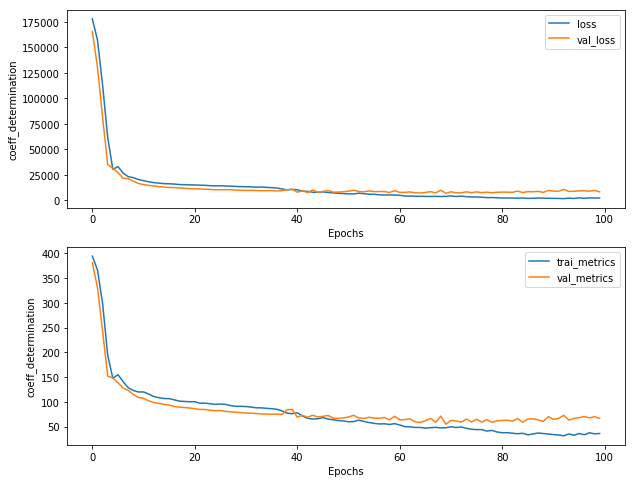

In [72]:
hist = history.history

plt.figure(figsize=(10, 8))


plt.subplot(211)
plt.plot(hist['loss'], label = 'loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("coeff_determination")
    
plt.subplot(212)
plt.plot(hist['mean_absolute_error'], label = 'trai_metrics')
plt.plot(hist['val_mean_absolute_error'], label='val_metrics')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("coeff_determination")
    

train R2 is 0.9115852395773751
test R2 is 0.5890711073683983
train mean abs err is 33.6829613235234
test mean abs err is 66.63402525583903


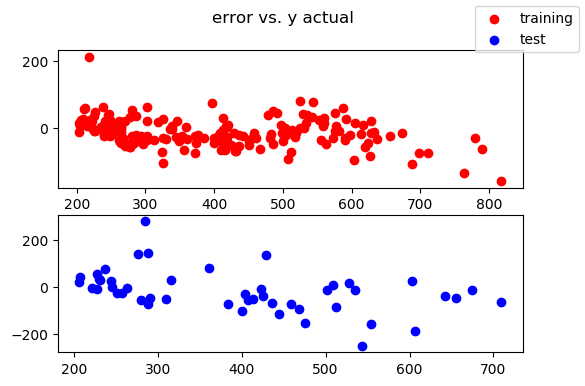

In [75]:
mutls.ModelUtils.plot_model_error(X_train, X_test, y_train, y_test, model)
print("train R2 is %s" % metrics.r2_score(y_train.reshape(-1,1),model.predict(X_train)))
print("test R2 is %s" % metrics.r2_score(y_test.reshape(-1,1),model.predict(X_test)))
print("train mean abs err is %s" % metrics.mean_absolute_error(y_train.reshape(-1,1),model.predict(X_train)))
print("test mean abs err is %s" % metrics.mean_absolute_error(y_test.reshape(-1,1),model.predict(X_test)))

#### use the first model for subsampled data

In [80]:
hidden_size = 50
model = Sequential()
model.add(Embedding(len(wordmap), hidden_size, input_length=maxlen+5))
model.add(BatchNormalization())
model.add(LSTM(hidden_size, return_sequences=True))

model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(Dense(hidden_size, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

In [81]:
model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mean_absolute_error'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 279, 50)           2100      
_________________________________________________________________
batch_normalization_8 (Batch (None, 279, 50)           200       
_________________________________________________________________
lstm_22 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
lstm_23 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 279, 50)           0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 279, 50)           0         
__________

In [82]:
history = model.fit(X_train, y_train.reshape(-1,1), batch_size=32, validation_data=(X_test, y_test.reshape(-1,1)), epochs=100)

Train on 191 samples, validate on 48 samples
Epoch 1/100
191/191 [==============================] - 7s 39ms/step - loss: 177913.1995 - mean_absolute_error: 394.7540 - val_loss: 166460.5156 - val_mean_absolute_error: 382.6000
Epoch 2/100
191/191 [==============================] - 2s 12ms/step - loss: 159532.6413 - mean_absolute_error: 370.6090 - val_loss: 135441.0625 - val_mean_absolute_error: 339.0843
Epoch 3/100
191/191 [==============================] - 2s 12ms/step - loss: 120565.2846 - mean_absolute_error: 311.6531 - val_loss: 89347.2760 - val_mean_absolute_error: 260.5110
Epoch 4/100
191/191 [==============================] - 2s 12ms/step - loss: 71446.2946 - mean_absolute_error: 216.7489 - val_loss: 42690.8802 - val_mean_absolute_error: 158.7605
Epoch 5/100
191/191 [==============================] - 2s 12ms/step - loss: 33418.8363 - mean_absolute_error: 147.6201 - val_loss: 27866.1901 - val_mean_absolute_error: 144.2212
Epoch 6/100
191/191 [==============================] - 2s 13

191/191 [==============================] - 3s 14ms/step - loss: 6545.9714 - mean_absolute_error: 61.8123 - val_loss: 9993.5163 - val_mean_absolute_error: 75.0091
Epoch 48/100
191/191 [==============================] - 3s 14ms/step - loss: 6598.0541 - mean_absolute_error: 61.0231 - val_loss: 7014.0762 - val_mean_absolute_error: 66.4154
Epoch 49/100
191/191 [==============================] - 3s 14ms/step - loss: 6778.9765 - mean_absolute_error: 59.6859 - val_loss: 6666.8685 - val_mean_absolute_error: 63.6855
Epoch 50/100
191/191 [==============================] - 3s 14ms/step - loss: 6264.9246 - mean_absolute_error: 59.1544 - val_loss: 6762.9935 - val_mean_absolute_error: 63.2849
Epoch 51/100
191/191 [==============================] - 3s 14ms/step - loss: 5954.6305 - mean_absolute_error: 58.0360 - val_loss: 7004.8122 - val_mean_absolute_error: 63.0202
Epoch 52/100
191/191 [==============================] - 3s 14ms/step - loss: 5669.5447 - mean_absolute_error: 57.3408 - val_loss: 7117.047

Epoch 94/100
191/191 [==============================] - 3s 16ms/step - loss: 2126.1798 - mean_absolute_error: 35.7293 - val_loss: 8154.5368 - val_mean_absolute_error: 63.1075
Epoch 95/100
191/191 [==============================] - 3s 14ms/step - loss: 1589.9489 - mean_absolute_error: 30.9440 - val_loss: 8228.6904 - val_mean_absolute_error: 65.2548
Epoch 96/100
191/191 [==============================] - 3s 14ms/step - loss: 1586.6693 - mean_absolute_error: 31.0010 - val_loss: 8642.7786 - val_mean_absolute_error: 65.7087
Epoch 97/100
191/191 [==============================] - 3s 17ms/step - loss: 1511.4590 - mean_absolute_error: 30.0392 - val_loss: 8332.4023 - val_mean_absolute_error: 67.3677
Epoch 98/100
191/191 [==============================] - 3s 15ms/step - loss: 1466.9590 - mean_absolute_error: 29.1469 - val_loss: 8517.6370 - val_mean_absolute_error: 65.8704
Epoch 99/100
191/191 [==============================] - 3s 16ms/step - loss: 1500.4573 - mean_absolute_error: 29.3607 - val_l

Text(0, 0.5, 'coeff_determination')

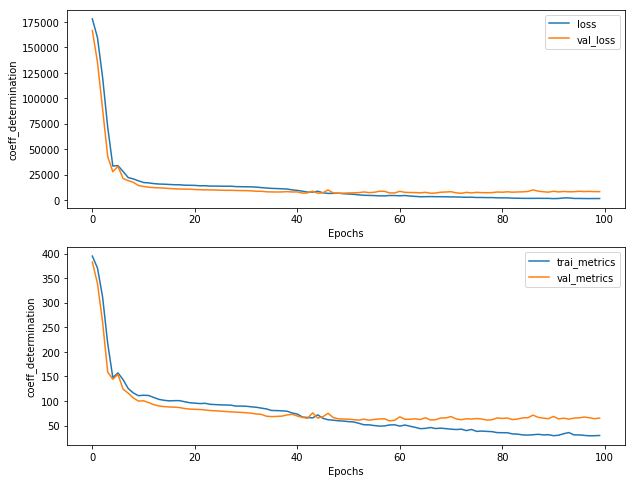

In [83]:
hist = history.history

plt.figure(figsize=(10, 8))


plt.subplot(211)
plt.plot(hist['loss'], label = 'loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("coeff_determination")
    
plt.subplot(212)
plt.plot(hist['mean_absolute_error'], label = 'trai_metrics')
plt.plot(hist['val_mean_absolute_error'], label='val_metrics')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("coeff_determination")
    

In [84]:
history1 = model.fit(X_train, y_train.reshape(-1,1), batch_size=32, validation_data=(X_test, y_test.reshape(-1,1)), epochs=25)

Train on 191 samples, validate on 48 samples
Epoch 1/25
191/191 [==============================] - 3s 13ms/step - loss: 1389.3137 - mean_absolute_error: 28.0965 - val_loss: 8381.7676 - val_mean_absolute_error: 64.9417
Epoch 2/25
191/191 [==============================] - 3s 14ms/step - loss: 1333.7421 - mean_absolute_error: 27.4527 - val_loss: 8277.6357 - val_mean_absolute_error: 67.2525
Epoch 3/25
191/191 [==============================] - 3s 13ms/step - loss: 1309.6092 - mean_absolute_error: 28.2313 - val_loss: 8445.3893 - val_mean_absolute_error: 66.7060
Epoch 4/25
191/191 [==============================] - 3s 14ms/step - loss: 1251.2312 - mean_absolute_error: 26.7386 - val_loss: 8421.1875 - val_mean_absolute_error: 64.6996
Epoch 5/25
191/191 [==============================] - 3s 13ms/step - loss: 1151.9435 - mean_absolute_error: 25.3548 - val_loss: 8308.9023 - val_mean_absolute_error: 64.4583
Epoch 6/25
191/191 [==============================] - 3s 14ms/step - loss: 1065.5872 - mea

Text(0, 0.5, 'coeff_determination')

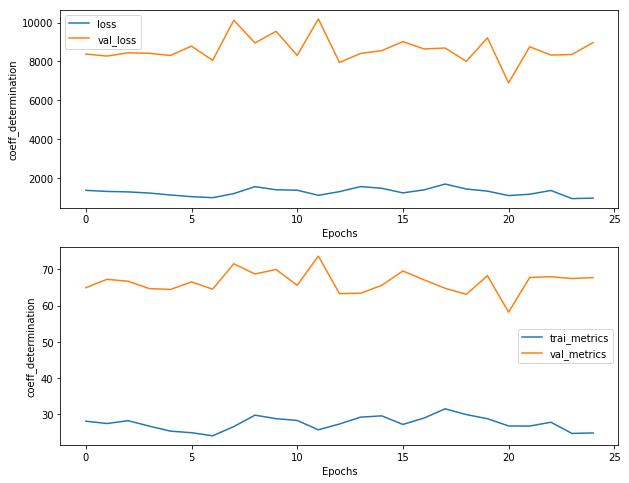

In [85]:
hist = history1.history

plt.figure(figsize=(10, 8))


plt.subplot(211)
plt.plot(hist['loss'], label = 'loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("coeff_determination")
    
plt.subplot(212)
plt.plot(hist['mean_absolute_error'], label = 'trai_metrics')
plt.plot(hist['val_mean_absolute_error'], label='val_metrics')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("coeff_determination")

train R2 is 0.9616880016136381
test R2 is 0.5536952500533732
train mean abs err is 22.151493450384493
test mean abs err is 67.71450010935466


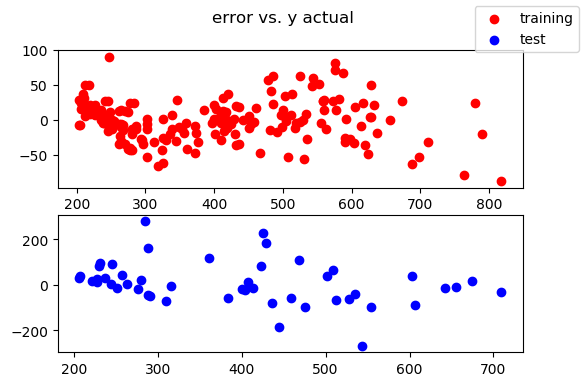

In [86]:
mutls.ModelUtils.plot_model_error(X_train, X_test, y_train, y_test, model)
print("train R2 is %s" % metrics.r2_score(y_train.reshape(-1,1),model.predict(X_train)))
print("test R2 is %s" % metrics.r2_score(y_test.reshape(-1,1),model.predict(X_test)))
print("train mean abs err is %s" % metrics.mean_absolute_error(y_train.reshape(-1,1),model.predict(X_train)))
print("test mean abs err is %s" % metrics.mean_absolute_error(y_test.reshape(-1,1),model.predict(X_test)))

#### Change loss function to mae

In [87]:
hidden_size = 50
model = Sequential()
model.add(Embedding(len(wordmap), hidden_size, input_length=maxlen+5))
model.add(BatchNormalization())
model.add(LSTM(hidden_size, return_sequences=True))

model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(Dense(hidden_size, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', optimizer='Adam', metrics=['mean_absolute_error'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 279, 50)           2100      
_________________________________________________________________
batch_normalization_9 (Batch (None, 279, 50)           200       
_________________________________________________________________
lstm_25 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
lstm_26 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
dropout_15 (Dropout)         (None, 279, 50)           0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
dropout_16 (Dropout)         (None, 279, 50)           0         
__________

In [88]:
history = model.fit(X_train, y_train.reshape(-1,1), batch_size=32, validation_data=(X_test, y_test.reshape(-1,1)), epochs=100)

Train on 191 samples, validate on 48 samples
Epoch 1/100
191/191 [==============================] - 8s 44ms/step - loss: 394.9259 - mean_absolute_error: 394.9259 - val_loss: 382.8200 - val_mean_absolute_error: 382.8200
Epoch 2/100
191/191 [==============================] - 2s 13ms/step - loss: 370.1566 - mean_absolute_error: 370.1566 - val_loss: 337.6318 - val_mean_absolute_error: 337.6318
Epoch 3/100
191/191 [==============================] - 2s 13ms/step - loss: 307.5661 - mean_absolute_error: 307.5661 - val_loss: 254.9130 - val_mean_absolute_error: 254.9130
Epoch 4/100
191/191 [==============================] - 2s 13ms/step - loss: 207.2190 - mean_absolute_error: 207.2190 - val_loss: 155.0163 - val_mean_absolute_error: 155.0163
Epoch 5/100
191/191 [==============================] - 2s 13ms/step - loss: 142.0699 - mean_absolute_error: 142.0699 - val_loss: 144.9233 - val_mean_absolute_error: 144.9233
Epoch 6/100
191/191 [==============================] - 2s 13ms/step - loss: 147.3950 

191/191 [==============================] - 3s 14ms/step - loss: 64.7917 - mean_absolute_error: 64.7917 - val_loss: 61.4648 - val_mean_absolute_error: 61.4648
Epoch 49/100
191/191 [==============================] - 3s 14ms/step - loss: 63.0773 - mean_absolute_error: 63.0773 - val_loss: 61.3986 - val_mean_absolute_error: 61.3986
Epoch 50/100
191/191 [==============================] - 3s 14ms/step - loss: 63.1770 - mean_absolute_error: 63.1770 - val_loss: 59.6825 - val_mean_absolute_error: 59.6825
Epoch 51/100
191/191 [==============================] - 3s 14ms/step - loss: 61.7353 - mean_absolute_error: 61.7353 - val_loss: 64.6401 - val_mean_absolute_error: 64.6401
Epoch 52/100
191/191 [==============================] - 3s 14ms/step - loss: 62.6761 - mean_absolute_error: 62.6761 - val_loss: 61.8551 - val_mean_absolute_error: 61.8551
Epoch 53/100
191/191 [==============================] - 3s 14ms/step - loss: 61.7667 - mean_absolute_error: 61.7667 - val_loss: 60.7195 - val_mean_absolute_er

Epoch 96/100
191/191 [==============================] - 3s 18ms/step - loss: 31.8697 - mean_absolute_error: 31.8697 - val_loss: 71.2605 - val_mean_absolute_error: 71.2605
Epoch 97/100
191/191 [==============================] - 3s 17ms/step - loss: 32.7218 - mean_absolute_error: 32.7218 - val_loss: 75.6577 - val_mean_absolute_error: 75.6577
Epoch 98/100
191/191 [==============================] - 3s 17ms/step - loss: 31.0718 - mean_absolute_error: 31.0718 - val_loss: 75.4934 - val_mean_absolute_error: 75.4934
Epoch 99/100
191/191 [==============================] - 3s 15ms/step - loss: 32.2433 - mean_absolute_error: 32.2433 - val_loss: 71.6274 - val_mean_absolute_error: 71.6274
Epoch 100/100
191/191 [==============================] - 3s 15ms/step - loss: 30.9771 - mean_absolute_error: 30.9771 - val_loss: 71.9451 - val_mean_absolute_error: 71.9451


(0, 150)

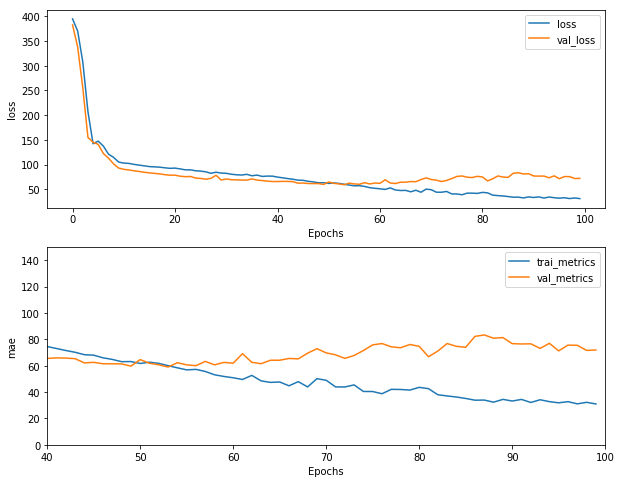

In [92]:
hist = history.history

plt.figure(figsize=(10, 8))


plt.subplot(211)
plt.plot(hist['loss'], label = 'loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
    
plt.subplot(212)
plt.plot(hist['mean_absolute_error'], label = 'trai_metrics')
plt.plot(hist['val_mean_absolute_error'], label='val_metrics')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("mae")
plt.xlim(40,100)
plt.ylim(0,150)

Overfitting problem after  60 epochs

train R2 is 0.8895121619804267
test R2 is 0.4357375266947686
train mean abs err is 27.207372861532644
test mean abs err is 71.94512144724528


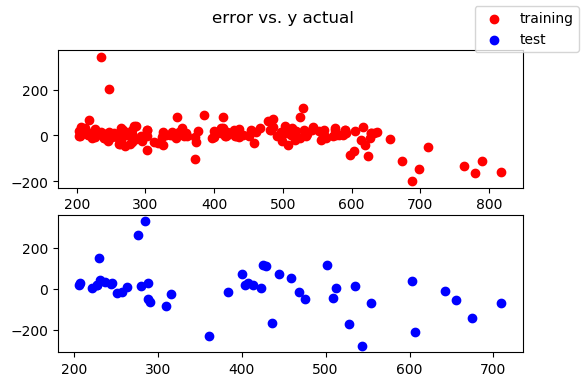

In [93]:
mutls.ModelUtils.plot_model_error(X_train, X_test, y_train, y_test, model)
print("train R2 is %s" % metrics.r2_score(y_train.reshape(-1,1),model.predict(X_train)))
print("test R2 is %s" % metrics.r2_score(y_test.reshape(-1,1),model.predict(X_test)))
print("train mean abs err is %s" % metrics.mean_absolute_error(y_train.reshape(-1,1),model.predict(X_train)))
print("test mean abs err is %s" % metrics.mean_absolute_error(y_test.reshape(-1,1),model.predict(X_test)))

In [95]:
hidden_size = 50
model = Sequential()
model.add(Embedding(len(wordmap), hidden_size, input_length=maxlen+5))
model.add(BatchNormalization())
model.add(LSTM(hidden_size, return_sequences=True))

model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(Dense(hidden_size, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', optimizer='Adam', metrics=['mean_absolute_error'])
model.summary()


history = model.fit(X_train, y_train.reshape(-1,1), batch_size=32, validation_data=(X_test, y_test.reshape(-1,1)), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 279, 50)           2100      
_________________________________________________________________
batch_normalization_10 (Batc (None, 279, 50)           200       
_________________________________________________________________
lstm_28 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
lstm_29 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
dropout_17 (Dropout)         (None, 279, 50)           0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 279, 50)           0         
__________

Epoch 39/50
191/191 [==============================] - 3s 17ms/step - loss: 65.2766 - mean_absolute_error: 65.2766 - val_loss: 73.4799 - val_mean_absolute_error: 73.4799
Epoch 40/50
191/191 [==============================] - 3s 14ms/step - loss: 62.9879 - mean_absolute_error: 62.9879 - val_loss: 72.6187 - val_mean_absolute_error: 72.6187
Epoch 41/50
191/191 [==============================] - 3s 13ms/step - loss: 61.5062 - mean_absolute_error: 61.5062 - val_loss: 75.3693 - val_mean_absolute_error: 75.3693
Epoch 42/50
191/191 [==============================] - 3s 13ms/step - loss: 65.4022 - mean_absolute_error: 65.4022 - val_loss: 69.3277 - val_mean_absolute_error: 69.3277
Epoch 43/50
191/191 [==============================] - 3s 13ms/step - loss: 64.3233 - mean_absolute_error: 64.3233 - val_loss: 72.3266 - val_mean_absolute_error: 72.3266
Epoch 44/50
191/191 [==============================] - 3s 14ms/step - loss: 61.9284 - mean_absolute_error: 61.9284 - val_loss: 73.4347 - val_mean_abso

In [96]:
history1 = model.fit(X_train, y_train.reshape(-1,1), batch_size=32, validation_data=(X_test, y_test.reshape(-1,1)), epochs=16)

Train on 191 samples, validate on 48 samples
Epoch 1/16
191/191 [==============================] - 3s 13ms/step - loss: 57.7990 - mean_absolute_error: 57.7990 - val_loss: 71.6639 - val_mean_absolute_error: 71.6639
Epoch 2/16
191/191 [==============================] - 2s 13ms/step - loss: 58.0874 - mean_absolute_error: 58.0874 - val_loss: 68.1783 - val_mean_absolute_error: 68.1783
Epoch 3/16
191/191 [==============================] - 2s 13ms/step - loss: 58.9780 - mean_absolute_error: 58.9780 - val_loss: 77.2997 - val_mean_absolute_error: 77.2997
Epoch 4/16
191/191 [==============================] - 3s 15ms/step - loss: 62.7726 - mean_absolute_error: 62.7726 - val_loss: 68.0884 - val_mean_absolute_error: 68.0884
Epoch 5/16
191/191 [==============================] - 3s 13ms/step - loss: 61.6788 - mean_absolute_error: 61.6788 - val_loss: 69.8187 - val_mean_absolute_error: 69.8187
Epoch 6/16
191/191 [==============================] - 3s 13ms/step - loss: 61.6666 - mean_absolute_error: 61.6

Text(0, 0.5, 'mae')

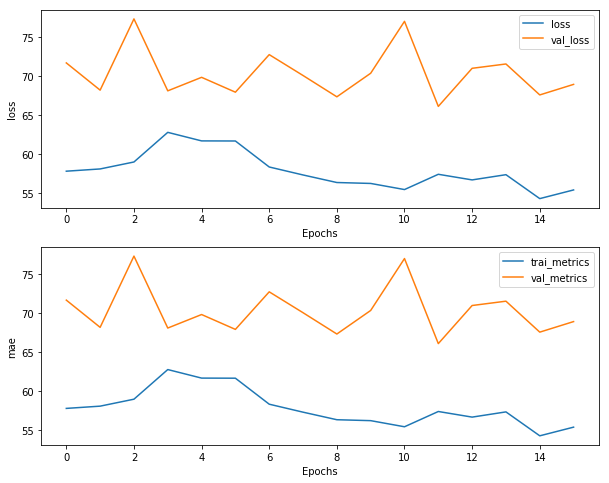

In [99]:
hist = history1.history

plt.figure(figsize=(10, 8))


plt.subplot(211)
plt.plot(hist['loss'], label = 'loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
    
plt.subplot(212)
plt.plot(hist['mean_absolute_error'], label = 'trai_metrics')
plt.plot(hist['val_mean_absolute_error'], label='val_metrics')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("mae")


train R2 is 0.6996641014190403
test R2 is 0.5804780025115928
train mean abs err is 53.68627808895412
test mean abs err is 68.91576067606609


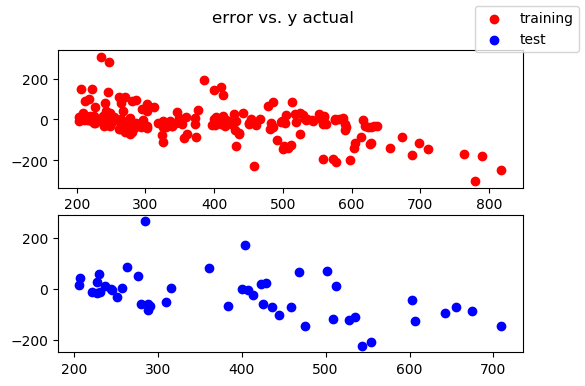

In [100]:
mutls.ModelUtils.plot_model_error(X_train, X_test, y_train, y_test, model)
print("train R2 is %s" % metrics.r2_score(y_train.reshape(-1,1),model.predict(X_train)))
print("test R2 is %s" % metrics.r2_score(y_test.reshape(-1,1),model.predict(X_test)))
print("train mean abs err is %s" % metrics.mean_absolute_error(y_train.reshape(-1,1),model.predict(X_train)))
print("test mean abs err is %s" % metrics.mean_absolute_error(y_test.reshape(-1,1),model.predict(X_test)))